In [1]:
import h5py

import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics

import sklearn.metrics 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

In [2]:
np.random.seed(20211012)
tf.random.set_seed(20211012)

## Load Data

In [3]:
CBIS = h5py.File('../input/cbisddsm/CBIS-DDSM.hdf5', 'r')
CBIS.keys()

<KeysViewHDF5 ['Calc-Test_ROI', 'Calc-Test_ROI_csv', 'Calc-Test_csv', 'Calc-Test_image', 'Calc-Training_ROI', 'Calc-Training_ROI_csv', 'Calc-Training_csv', 'Calc-Training_image', 'Mass-Test_ROI', 'Mass-Test_ROI_csv', 'Mass-Test_csv', 'Mass-Test_image', 'Mass-Training_ROI', 'Mass-Training_ROI_csv', 'Mass-Training_csv', 'Mass-Training_image']>

### CSV

In [4]:
Mass_Training_image_csv = CBIS['Mass-Training_csv'][:]
Calc_Training_image_csv = CBIS['Calc-Training_csv'][:]

Mass_Training_ROI_csv = CBIS['Mass-Training_ROI_csv'][:]
Calc_Training_ROI_csv = CBIS['Calc-Training_ROI_csv'][:]

Mass_Test_image_csv = CBIS['Mass-Test_csv'][:]
Calc_Test_image_csv = CBIS['Calc-Test_csv'][:]

Mass_Test_ROI_csv = CBIS['Mass-Test_ROI_csv'][:]
Calc_Test_ROI_csv = CBIS['Calc-Test_ROI_csv'][:]

In [5]:
Mass_Test_image_csv[152]

array([b'P_00677', b'RIGHT', b'CC'], dtype='|S10')

### Image

In [6]:
Mass_Training_image = CBIS['Mass-Training_image'][:]
Calc_Training_image = CBIS['Calc-Training_image'][:]

Mass_Test_image = CBIS['Mass-Test_image'][:]
Calc_Test_image = CBIS['Calc-Test_image'][:]

Mass_Training_ROI = CBIS['Mass-Training_ROI'][:]
Calc_Training_ROI = CBIS['Calc-Training_ROI'][:]

Mass_Test_ROI = CBIS['Mass-Test_ROI'][:]
Calc_Test_ROI = CBIS['Calc-Test_ROI'][:]

## Data Preparation

### Data Balance

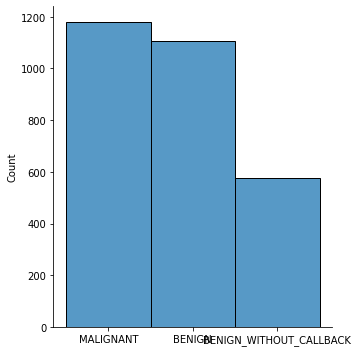

In [7]:
sns.displot(np.concatenate(
    [Mass_Training_ROI_csv['pathology'], 
     Calc_Training_ROI_csv['pathology']])
           )

## Response variables

### Pathology

Benign cases are formed from screening exams in which something suspicious was found, but was determined to not be malignant (by pathology, ultrasound or some other means). The term benign without callback is used to identify benign cases in which no additional films or biopsy was done to make the benign finding. These cases, however, contained something interesting enough for the radiologist to mark. **A small number of cancer cases may contain, in addition to one or more regions that are path-proven malignant, one or more regions that are unproven.** These are suspicious regions for which there is no path result. 

Since there are only a small number of malignant case in benign without callback, we will map 'benign without callback' into benign

In [8]:
def modifyPathology(df):
    x = df['pathology']
    df['pathology'] = np.where(x == b'BENIGN_WITHOUT_CALLBACK', b'BENIGN', x)
    return df

In [9]:
Mass_Training_ROI_csv = modifyPathology(Mass_Training_ROI_csv)
Calc_Training_ROI_csv = modifyPathology(Calc_Training_ROI_csv)
Mass_Test_ROI_csv = modifyPathology(Mass_Test_ROI_csv)
Calc_Test_ROI_csv = modifyPathology(Calc_Test_ROI_csv)

For each X-ray image, multiple abnormality may found. We consider that if any of the abnormality is malignant, the image will be signed as malignant. We also defines benign as 0 and malignant as 1.

In [10]:
def class2onehot(array, n_class = 2):
    b = np.zeros((array.size, 2), dtype = np.int32)
    b[np.arange(array.size),array] = 1
    return b

def AbnormalityAggregate(images, roi):
    Pathologys_array = []
    for img in tqdm(images):
        id_match = roi[roi['patient_id'] == img[0]]
        breast_match = id_match[id_match['left or right breast'] == img[1]]
        view_match = breast_match[breast_match['image view'] == img[2]]
        
        Pathology = 0
        for i in view_match:
            if(i[4] == b'MALIGNANT'):
                Pathology = 1
                break
        Pathologys_array.append(Pathology)
        onehot = class2onehot(np.array(Pathologys_array, dtype = np.int32))
    return onehot

In [11]:
y1_Mass_Training_Pathology = AbnormalityAggregate(Mass_Training_image_csv, Mass_Training_ROI_csv)
y1_Calc_Training_Pathology = AbnormalityAggregate(Calc_Training_image_csv, Calc_Training_ROI_csv)
y1_Mass_Test_Pathology = AbnormalityAggregate(Mass_Test_image_csv, Mass_Test_ROI_csv)
y1_Calc_Test_Pathology = AbnormalityAggregate(Calc_Test_image_csv, Calc_Test_ROI_csv)

100%|██████████| 284/284 [00:00<00:00, 15964.38it/s]


Since the model should and will only one output for ROI. We will merge all the ROI image for a patient into one image

In [12]:
def ROIMerge(images_csv, roi_csv, roi):
    roi_array = np.zeros(shape = (len(images_csv), 224,224), dtype = np.int32)
    for i in tqdm(range(len(images_csv))):
        img = images_csv[i]
        id_match     = roi_csv['patient_id'] == img[0]
        breast_match = roi_csv['left or right breast'] == img[1]
        view_match   = roi_csv['image view'] == img[2]
        
        all_match = id_match & breast_match & view_match
        
        roi_array[i] = (np.sum(roi[all_match], axis = 0) > 0)
        
    return roi_array

In [13]:
y2_Mass_Training_ROI = ROIMerge(Mass_Training_image_csv, Mass_Training_ROI_csv, Mass_Training_ROI)
y2_Calc_Training_ROI = ROIMerge(Calc_Training_image_csv, Calc_Training_ROI_csv, Calc_Training_ROI)
y2_Mass_Test_ROI = ROIMerge(Mass_Test_image_csv, Mass_Test_ROI_csv, Mass_Test_ROI)
y2_Calc_Test_ROI = ROIMerge(Calc_Test_image_csv, Calc_Test_ROI_csv, Calc_Test_ROI)

100%|██████████| 284/284 [00:00<00:00, 2189.32it/s]


### Data concatenating

In [14]:
X_train = np.concatenate([Mass_Training_image, Calc_Training_image])[..., np.newaxis]
X_test = np.concatenate([Mass_Test_image, Calc_Test_image])[..., np.newaxis]

Y1_train = np.concatenate([y1_Mass_Training_Pathology, y1_Calc_Training_Pathology])
Y1_test = np.concatenate([y1_Mass_Test_Pathology, y1_Calc_Test_Pathology])

Y2_train = np.concatenate([y2_Mass_Training_ROI, y2_Calc_Training_ROI])
Y2_test = np.concatenate([y2_Mass_Test_ROI, y2_Calc_Test_ROI])

### Grayscale to RGB

In [15]:
X_train = np.concatenate([X_train,X_train,X_train], axis =3)
X_test = np.concatenate([X_test,X_test,X_test], axis =3)

### Random shuffle and Train validation split

In [16]:
shuffle_order = np.arange(len(X_train))
np.random.shuffle(shuffle_order)
shuffle_order

array([1972, 1051, 1814, ...,   70, 1559,  427])

In [17]:
validation_size = .2
validation_size = int(len(shuffle_order)*validation_size)

In [18]:
train_idx = shuffle_order[validation_size:]
validation_idx = shuffle_order[:validation_size]

In [19]:
X_val = X_train[validation_idx]
Y1_val = Y1_train[validation_idx]
Y2_val = Y2_train[validation_idx]

In [20]:
X_train = X_train[train_idx]
Y1_train = Y1_train[train_idx]
Y2_train = Y2_train[train_idx]

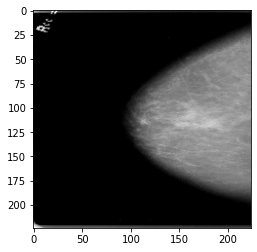

In [21]:
plt.imshow(X_test[152])

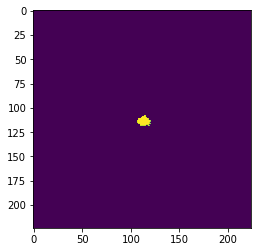

In [22]:
plt.imshow(Y2_test[152])

### ROI class weight

Text(0.5, 0, 'Class')

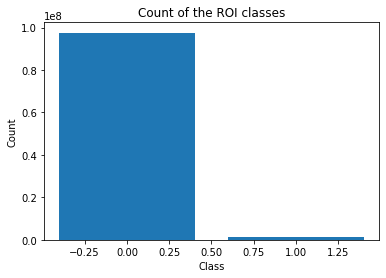

In [23]:
unique, count = np.unique(Y2_train.flatten(), return_counts = True)
plt.bar(unique, count)
plt.title('Count of the ROI classes')
plt.ylabel('Count')
plt.xlabel('Class')

Since the normal area is sigificantly more than abnormal area, we will give heavily weight on malignant class. https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [24]:
ROIweights = class_weight.compute_class_weight('balanced',
                                                unique,
                                                Y2_train.flatten())
ROIweights = {0: ROIweights[0], 1: ROIweights[1]}
ROIweights

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.5057283710819899, 1: 44.14242407165393}

## Model 1: Single tasking

In [25]:
m1 = keras.models.load_model("../input/cbisddsmtrainingresult/m1/m1-20.hdf5")

2021-11-10 04:06:38.937512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 04:06:39.055404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 04:06:39.056828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-10 04:06:39.058842: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Model1 evalidation

In [26]:
def confusion2measure(cm):
    tn, fp, fn, tp = cm.ravel()
    
    p = tp + fn
    n = fp + tn
    
    pp = tp + fp
    pn = fn + tn
    
    print(f"Accuracy:   {(tp + tn)/(p + n)}")
    print(f"Precision:  {tp / pp}")
    print(f"Recall:     {tp / p}")
    
    print(f"NPV:        {tn / pn}")
    print(f"Specificity:{tn / n}")

In [27]:
def eval_model_M1(model, x_test, y_test, title, label_name = ['benign', 'malignant']):
    pred = model.predict(x_test)
    pred_mostlikeyi = class2onehot(np.argmax(pred, axis = 1))


    cm = confusion_matrix(
        y_true = y_test[:,1], 
        y_pred = pred_mostlikeyi[:,1], 
        labels = [0,1]
    )
    
    confusion2measure(cm)
    
    plt.figure(figsize=(5,5))
    ax = plt.subplot(1,1,1)
    sns.heatmap(cm, cmap = 'viridis', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f"Confusion matrix for {title}")
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show()

2021-11-10 04:06:50.099532: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-10 04:06:52.754534: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Accuracy:   0.7742755465175394
Precision:  0.7157996146435452
Recall:     0.8329596412556054
NPV:        0.8396124865446717
Specificity:0.7255813953488373


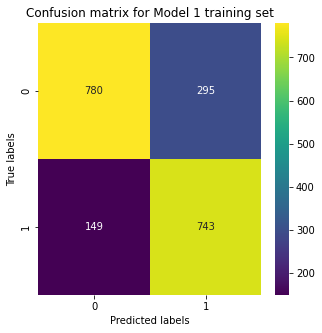

In [28]:
eval_model_M1(m1, X_train, Y1_train, "Model 1 training set")

Accuracy:   0.6639511201629328
Precision:  0.6022727272727273
Recall:     0.726027397260274
NPV:        0.73568281938326
Specificity:0.6139705882352942


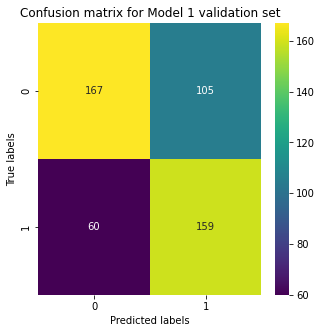

In [29]:
eval_model_M1(m1, X_val, Y1_val, "Model 1 validation set")

Accuracy:   0.6341085271317829
Precision:  0.5426829268292683
Recall:     0.6742424242424242
NPV:        0.7287066246056783
Specificity:0.6062992125984252


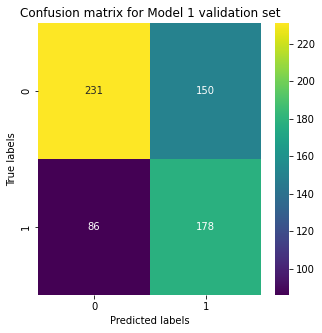

In [30]:
eval_model_M1(m1, X_test, Y1_test, "Model 1 validation set")

## Model 2: Multitask learning

In [31]:
def weighted_binary_cross_entropy(weights: dict, from_logits: bool = False):
    assert 0 in weights
    assert 1 in weights

    def weighted_cross_entropy_fn(y_true, y_pred):
        
        size = tf.math.reduce_prod(tf.shape(y_pred))
        
        tf_y_true = tf.reshape(tf.cast(y_true, dtype=y_pred.dtype), [size,1])
        tf_y_pred = tf.reshape(tf.cast(y_pred, dtype=y_pred.dtype), [size,1])
        
        weights_v = tf.cast(tf.where(tf.equal(tf_y_true, 1), weights[1], weights[0]), dtype=y_pred.dtype)
        ce = tf.reshape(metrics.binary_crossentropy(tf_y_true, tf_y_pred, from_logits=from_logits), [size,1])
        weighted_loss = tf.math.multiply(ce, weights_v)
        loss = tf.math.reduce_mean(weighted_loss)
        return loss

    return weighted_cross_entropy_fn

In [32]:
m2 = keras.models.load_model("../input/cbisddsmtrainingresult/m2/m2-50.hdf5", custom_objects={"weighted_cross_entropy_fn": weighted_binary_cross_entropy(ROIweights)})

### Model 2 evaluation

In [33]:
def eval_model_M2_Y1(model, x_test, y1_test, y2_test, title, label_name = ['Benign', 'Malignant']):
    ## Y1 Pathology
    Y1_pred, Y2_pred = m2.predict(x_test)
    pred_mostlikeyi = class2onehot(np.argmax(Y1_pred, axis = 1))
    
    cm = confusion_matrix(
        y_true = y1_test[:,1], 
        y_pred = pred_mostlikeyi[:,1], 
        labels = [0,1]
    )
    plt.figure(figsize=(5,5))
    ax = plt.subplot(1,1,1)

    sns.heatmap(cm, cmap = 'viridis', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f"Confusion matrix for {title}")
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show()
    
    
    ## Y2 Pathology
    Y2_pred = (Y2_pred.flatten()>0.5).astype(np.int32)
    y2_test = y2_test.flatten()
    
        
    cm = confusion_matrix(
        y_true = y2_test, 
        y_pred = Y2_pred, 
        labels = [0,1]
    )
    

    
    plt.figure(figsize=(5,5))
    ax = plt.subplot(1,1,1)
    sns.heatmap(cm, cmap = 'viridis', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f"Confusion Matrix for ROI for {title}")
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show()
    


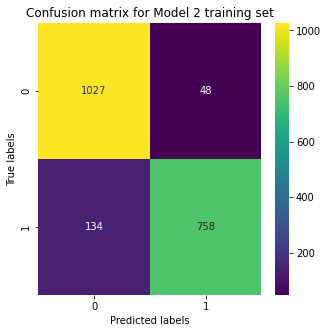

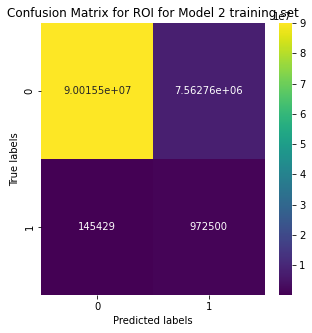

In [34]:
eval_model_M2_Y1(m2, X_train, Y1_train, Y2_train, "Model 2 training set")

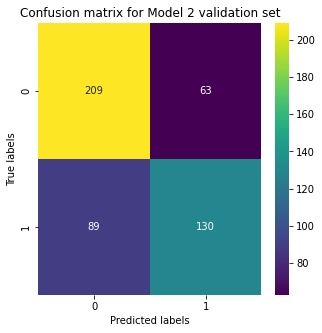

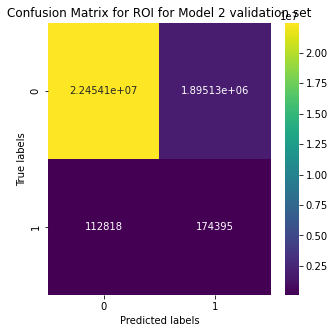

In [35]:
eval_model_M2_Y1(m2, X_val, Y1_val, Y2_val, "Model 2 validation set")

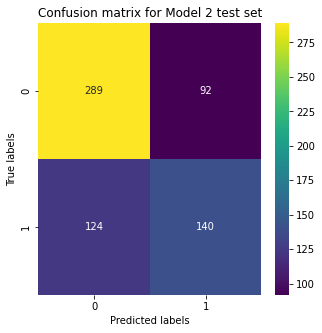

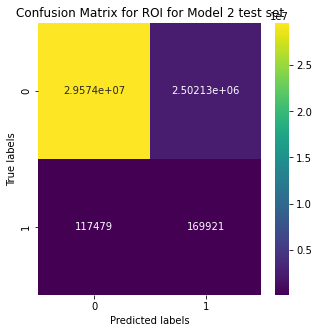

In [36]:
eval_model_M2_Y1(m2, X_test, Y1_test, Y2_test, "Model 2 test set")

#### ROI prediction evaluation

In [37]:
def plotPredictROI(Y_predic, x_test, y1_test, y2_test, n = 5):
    shuffle_order = np.arange(len(x_test))
    np.random.shuffle(shuffle_order)
    
    x_test = x_test[shuffle_order[:n]]
    y2_test = y2_test[shuffle_order[:n]]
    Y1_pred, Y2_pred = m2.predict(x_test)

    
    fig, ax = plt.subplots(n, 3, figsize=(15,n*5))
    
    for i in range(n):
        ax[i,0].imshow(x_test[i])
        ax[i,0].set_title(shuffle_order[i])
        ax[i,1].imshow(y2_test[i])
        ax[i,2].imshow(Y2_pred[i]>0.5)
        
    plt.show()
            
    
    

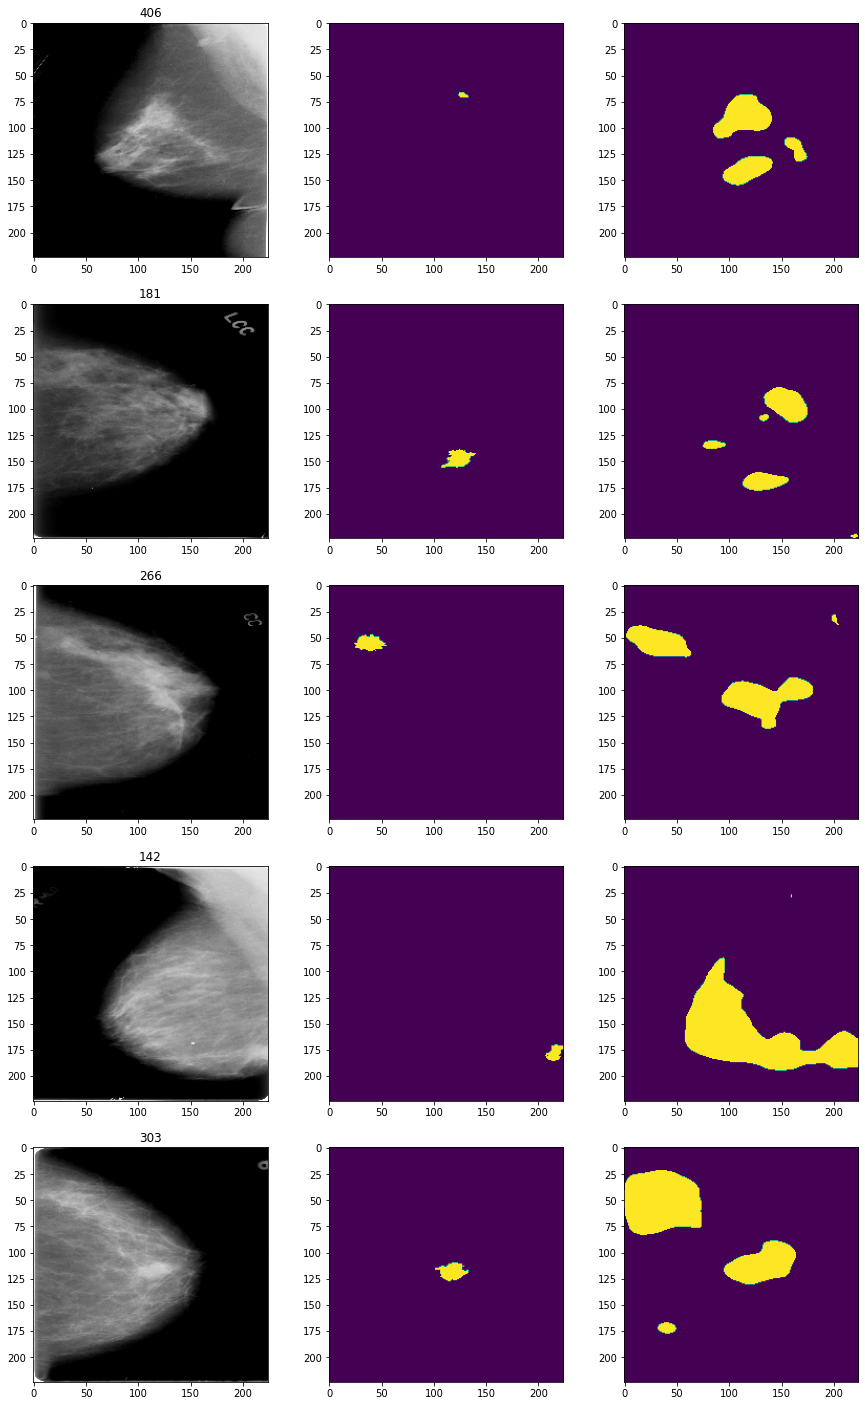

In [38]:
plotPredictROI(m2, X_test, Y1_test, Y2_test)

## ROC curve

In [39]:

def model2ROCplot(y1_pred: list, y1_test, name: list):
    fpr = list()
    tpr = list()
    roc_auc = list()
    for i in range(len(y1_pred)):
        fpr_i, tpr_i, _ = roc_curve(y1_test[:,1], y1_pred[i][:,1])
        roc_auc.append(auc(fpr_i, tpr_i))
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        
    plt.figure(figsize=(7,7))
    for i in range(len(y1_pred)):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = {0:0.2f}) for {1}'.format(roc_auc[i], name[i]))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) for model 1 and model 2 on test set')
    plt.legend(loc="lower right")
    plt.show()
        

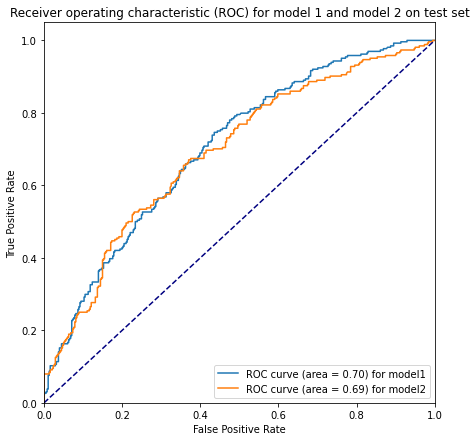

In [40]:
model2ROCplot([m1.predict(X_test), m2.predict(X_test)[0]], Y1_test, ['model1', 'model2'])

## Model plot

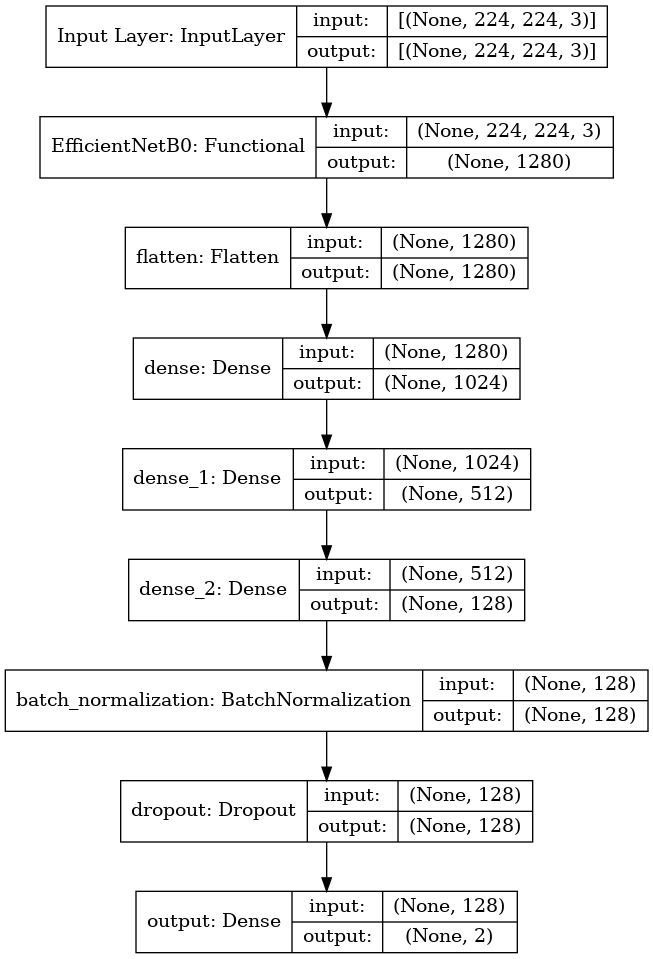

In [41]:
keras.utils.plot_model(m1,show_shapes=True)

In [42]:
keras.utils.plot_model(m2,show_shapes=True)

## Some unuse code

Abnormal size analysis

In [43]:
train_ROI_all = np.concatenate([CBIS['Calc-Training_ROI'],CBIS['Mass-Training_ROI']],axis = 0)

In [44]:
larger100 = (np.max(np.sum(train_ROI_all/255, axis = 1),axis = 1) > 80) | (np.max(np.sum(train_ROI_all/255, axis = 2),axis = 1) > 100)

In [45]:
abnormal_size = np.concatenate([
                    np.max(np.sum(train_ROI_all/255, axis = 1),axis = 1),
                    np.max(np.sum(train_ROI_all/255, axis = 2),axis = 1)
                ],
                axis = 0)

In [46]:
np.mean(abnormal_size)

20.604224860335197

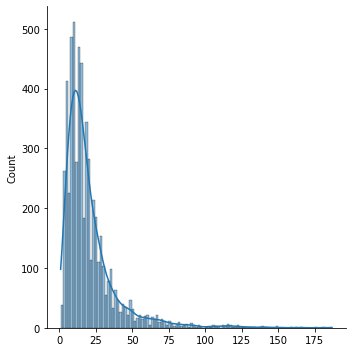

In [47]:
sns.displot(abnormal_size, kde=True)